In [38]:
import pandas as pd
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline
plt.style.use("ggplot")
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Set the figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)

## Persistence Model

I want to develop a model to predict the last 7 days of minimum temperatures in the dataset given all prior observations

Test MSE: 18.216


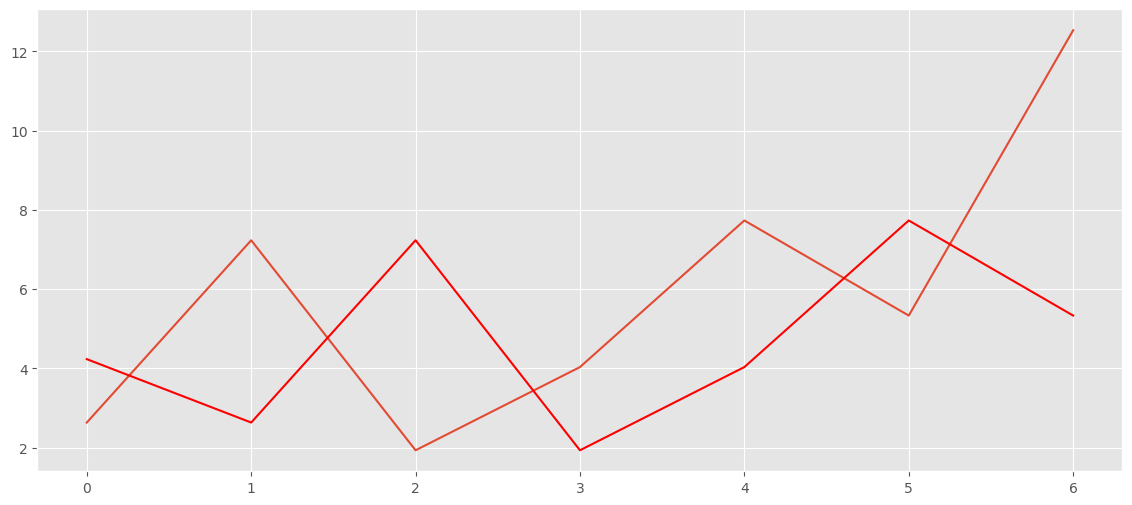

In [45]:
series = pd.read_csv('df_remainder.csv', header=0, index_col=0)
# create lagged dataset
values = pd.DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
 
# persistence model
def model_persistence(x):
 return x
 
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()


### Autocorrelation Plots

We can plot the correlation coefficient for each lag variable.

This can very quickly give an idea of which lag variables may be good candidates for use in a predictive model and how the relationship between the observation and its historic values changes over time.

We could manually calculate the correlation values for each lag variable and plot the result. Thankfully, Pandas provides a built-in plot called the autocorrelation_plot() function.

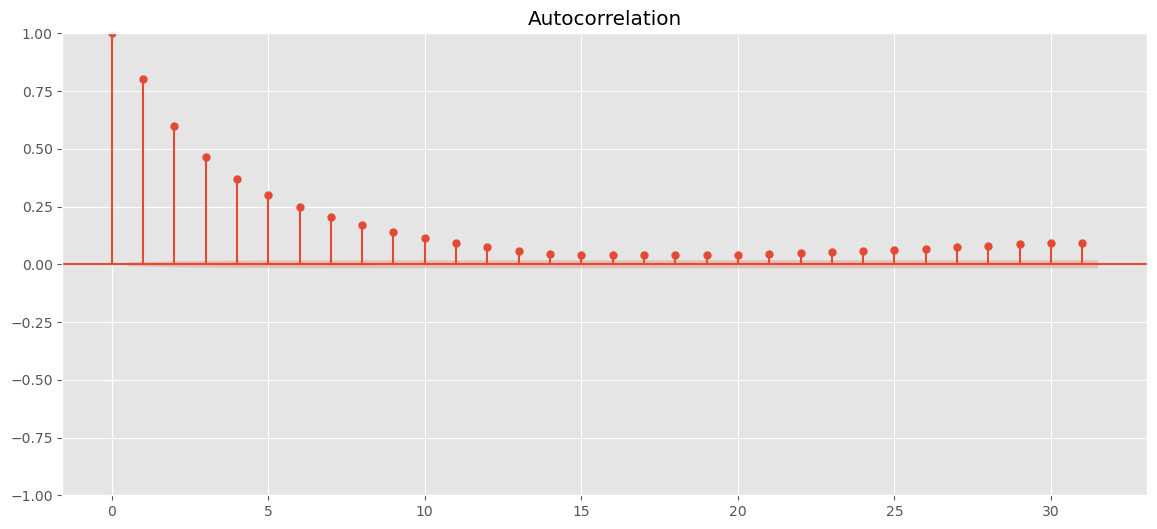

In [83]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series, lags=31)
pyplot.show()

In [46]:
test_y

array([ 2.63080485,  7.23077102,  1.9307372 ,  4.03070338,  7.73066956,
        5.33063574, 12.53060192])

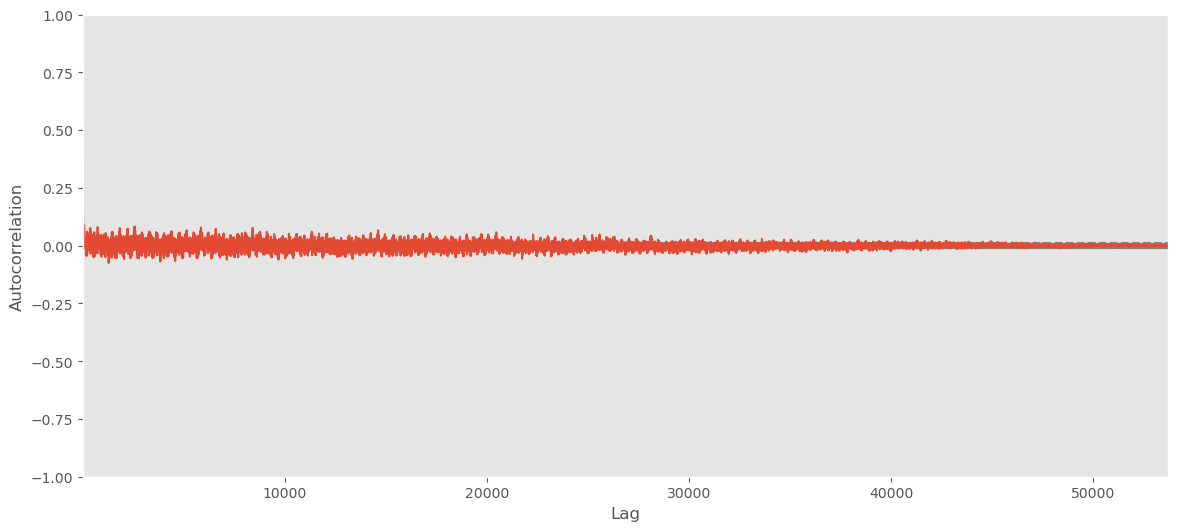

In [85]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
pyplot.show()

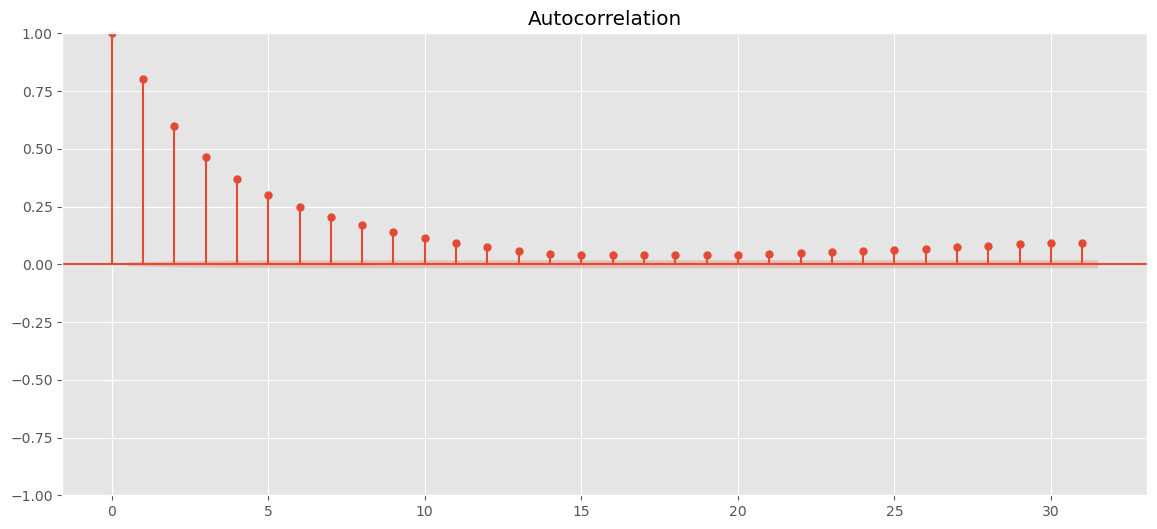

In [86]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series, lags=31)
pyplot.show()

## Autoregression Model

Coefficients: [ 1.91962210e-05  9.17410587e-01 -1.94932031e-01  5.68648051e-02
  4.05450655e-03  9.96331738e-03  3.06454685e-04  7.62212869e-04
  8.07690519e-03 -2.45480518e-03  1.52270607e-03 -3.51186764e-03
  3.66555927e-03 -7.35699303e-03 -9.96117529e-04 -3.68139035e-04
  2.54299170e-03  1.92919874e-03 -4.03493138e-04  8.20860250e-03
 -8.67498149e-03  2.37842262e-03  5.53087217e-03  2.95235537e-03
 -2.35471725e-03  1.74272434e-03  5.81043697e-03  2.06401319e-03
 -4.38268820e-03  2.09682484e-02]
predicted=3.375047, expected=2.630805
Test RMSE: 5.698
predicted=2.504748, expected=7.230771
Test RMSE: 5.698
predicted=1.945835, expected=1.930737
Test RMSE: 5.698
predicted=1.571374, expected=4.030703
Test RMSE: 5.698
predicted=1.268853, expected=7.730670
Test RMSE: 5.698
predicted=0.998228, expected=5.330636
Test RMSE: 5.698
predicted=0.790341, expected=12.530602
Test RMSE: 5.698


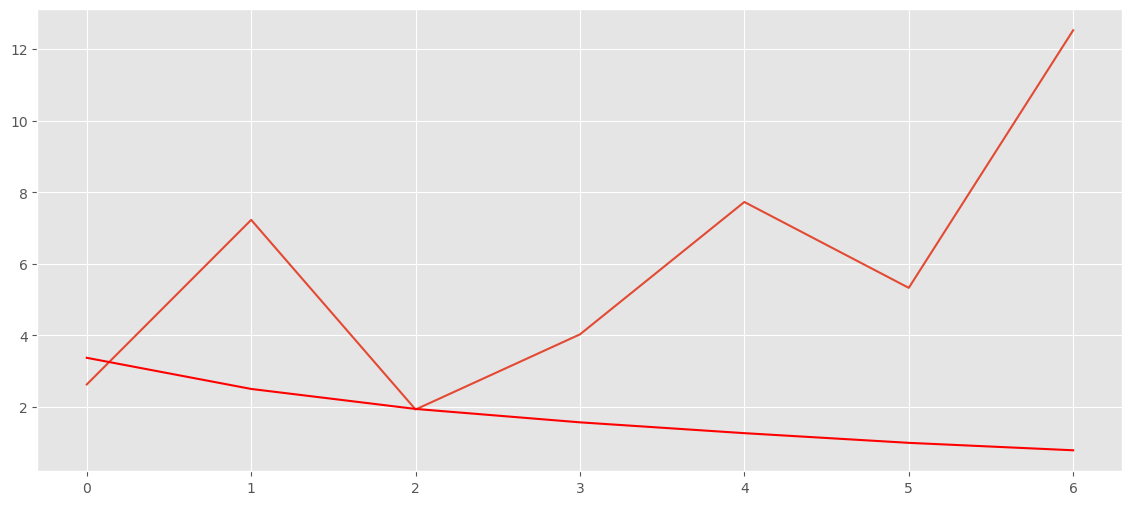

In [49]:
from math import sqrt
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AutoReg(train, lags=29)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
    rmse = sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

#### The statsmodels API does not make it easy to update the model as new observations become available.

One way would be to re-train the AutoReg model each day as new observations become available, and that may be a valid approach, if not computationally expensive.

An alternative would be to use the learned coefficients and manually make predictions. This requires that the history of 29 prior observations be kept and that the coefficients be retrieved from the model and used in the regression equation to come up with new forecasts.

The coefficients are provided in an array with the intercept term followed by the coefficients for each lag variable starting at t-1 to t-n. We simply need to use them in the right order on the history of observations, as follows:

In [54]:
X.shape

(53691, 1)

In [55]:
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
window = 29
model = AutoReg(train, lags=29)
model_fit = model.fit()
coef = model_fit.params


In [57]:
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()

In [58]:
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    

In [62]:
for d in range(window):
    yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    

In [64]:
print('predicted=%f, expected=%f' % (yhat, obs))



predicted=15.019295, expected=12.530602


In [81]:
#predictions

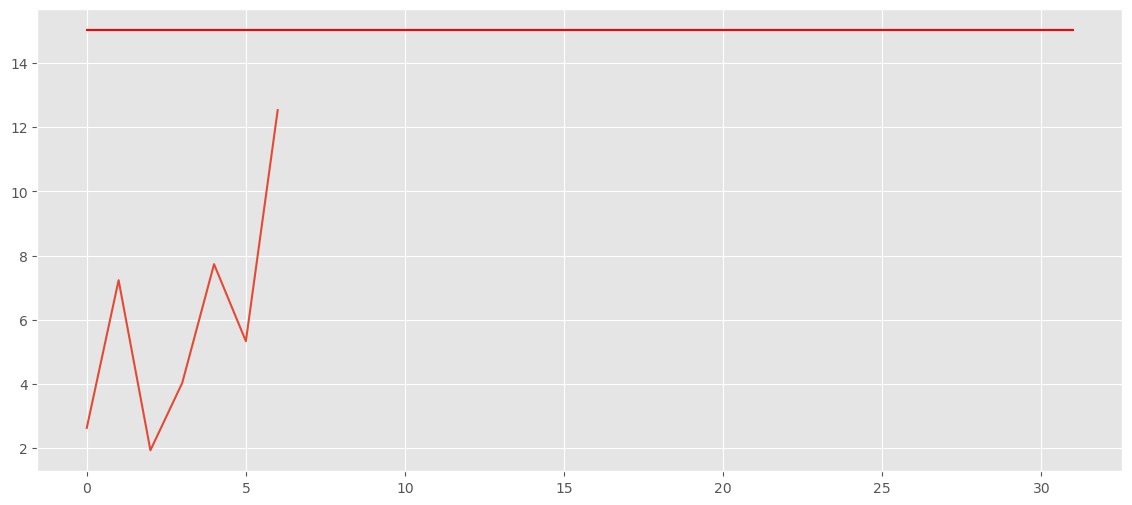

In [80]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()